<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tensorflow/tf_low_level_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Level TensorFlow, Part III: Layers and Training

* https://www.tensorflow.org/guide/low_level_intro#training
* https://developers.google.com/machine-learning/glossary/#gradient_descent
* https://developers.google.com/machine-learning/glossary/#optimizer

In [1]:
# import and check version
import tensorflow as tf
# tf can be really verbose
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [2]:
# a small sanity check, does tf seem to work ok? 
sess = tf.Session()
hello = tf.constant('Hello TF!')
print(sess.run(hello))
sess.close()

b'Hello TF!'


## Transforming an input to a known output

In [0]:
input = [[-1], [0], [1], [2], [3], [4]]
output = [[2], [1], [0], [-1], [-2], [-3]]

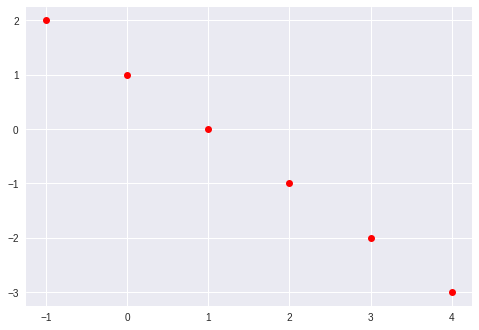

In [4]:
import matplotlib.pyplot as plt

plt.plot(input, output, 'ro')

### relation between input and output is linear

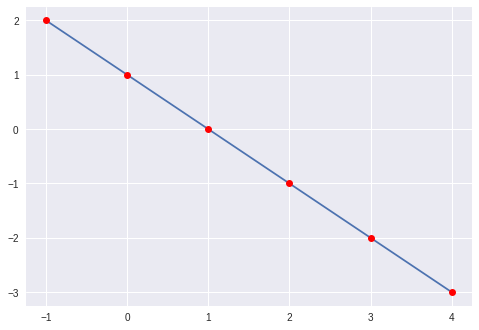

In [5]:
plt.plot(input, output)
plt.plot(input, output, 'ro')

In [6]:
x = tf.constant(input, dtype=tf.float32)
y_true = tf.constant(output, dtype=tf.float32)
y_true

<tf.Tensor 'Const_2:0' shape=(6, 1) dtype=float32>

## Defining the model to train

untrained single unit (neuron) also outputs a line from same input, although another one 

### The Artificial Neuron: Foundation of Deep Neural Networks (simplified, more later)

* a neuron takes a number of numerical inputs
* multiplies each with a weight, sums up all weighted input and  
* adds bias (constant) to that sum
* from this it creates a single numerical output
* for one input (one dimension) this would be a description of a line
* for more dimensions this describes a hyper plane that can serve as a decision boundary
* this is typically expressed as a matrix multplication plus an addition


<img src='https://djcordhose.github.io/ai/img/insurance/neuron211.jpg'>

### From single neuron to network in the TensorFlow Playground

<img src='https://djcordhose.github.io/ai/img/tf-plaground.png'>

https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.98437&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [7]:
# short version, though harder to inspect
# y_pred = tf.layers.dense(inputs=x, units=1)

# matrix multiplication under the hood
# tf.matmul(x, w) + b
linear_model = tf.layers.Dense(units=1) 
y_pred = linear_model(x)
y_pred

<tf.Tensor 'dense/BiasAdd:0' shape=(6, 1) dtype=float32>

In [8]:
# single neuron and single input: one weight and one bias
# weights and biases are represented as variables
# https://www.tensorflow.org/guide/variables
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  weights = sess.run(linear_model.trainable_weights)
  print(weights)

[array([[0.77791774]], dtype=float32), array([0.], dtype=float32)]


### Output of a single untrained neuron

[[-1.2249221]
 [ 0.       ]
 [ 1.2249221]
 [ 2.4498441]
 [ 3.674766 ]
 [ 4.8996882]]


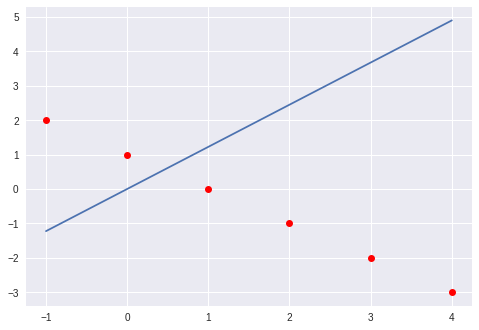

In [9]:
# when you execute this cell, you should see a different line, as the initialization is random
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  output_pred = sess.run(y_pred)
  print(output_pred)
  plt.plot(input, output_pred)
  plt.plot(input, output, 'ro')

## Loss - Mean Squared Error

Loss function is the prerequisite to training. We need an objective to optimize for. We calculate the difference between what we get as output and what we would like to get.

### Mean Squared Error

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [10]:
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)
loss

<tf.Tensor 'mean_squared_error/value:0' shape=() dtype=float32>

In [11]:
# when this loss is zero (which it is not right now) we get the desired output
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  print(sess.run(loss))

10.552988


### Minimize Loss by changing parameters of neuron

Move in parameter space in the direction of a descent

<img src='https://djcordhose.github.io/ai/img/gradients.jpg'>

https://twitter.com/colindcarroll/status/1089568839275368448

### Job of the optimizer

<img src='https://djcordhose.github.io/ai/img/manning/optimizer.png' height=500>



In [12]:
# move the parameters of our single neuron in the right direction with a pretty high intensity (learning rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)
train

<tf.Operation 'GradientDescent' type=NoOp>

In [0]:
losses = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# iterations aka epochs, optimizing the parameters of the neuron
for i in range(500):
  
  # executing optimizer and current loss, but only displaying current loss
  _, loss_value = sess.run((train, loss))
  losses.append(loss_value)

In [14]:
print(sess.run(loss))

1.52277335e-05


### Learning Curve after training

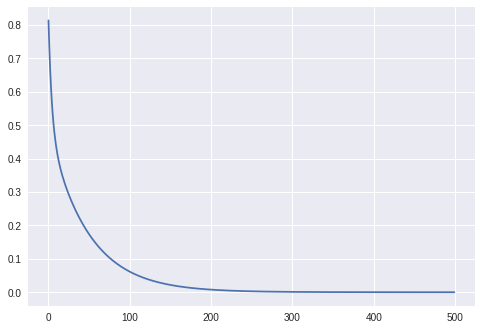

In [15]:
# wet dream of every machine learning person (typically you see a noisy curve only sort of going down)
plt.plot(losses)

### Line drawn by neuron after training

* result after training is not perfect, but almost looks like the same line
* https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form


[[ 1.9931635 ]
 [ 0.9948308 ]
 [-0.00350189]
 [-1.0018346 ]
 [-2.0001671 ]
 [-2.9984999 ]]


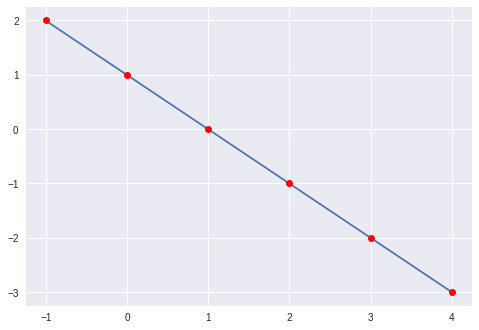

In [16]:
output_pred = sess.run(y_pred)
print(output_pred)
plt.plot(input, output_pred)
plt.plot(input, output, 'ro')

In [17]:
# single neuron and single input: one weight and one bias
# slope m ~ -1
# y-axis offset y0 ~ 1
# https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form

weights = sess.run(linear_model.trainable_weights)
print(weights)

[array([[-0.9983327]], dtype=float32), array([0.9948308], dtype=float32)]
